In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/raw/water_potability 2.csv')
print(data.head())
print(data.info())
print(data.describe())


         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  -

In [92]:
print(data.isnull().sum())


ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


In [93]:
data.dropna(inplace=True)

# Verify that null values have been removed
print(data.isnull().sum())

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


In [94]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB
None


In [95]:
#Feature enginerring
features = data.drop('Potability', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
data_scaled = pd.DataFrame(scaled_features, columns=features.columns)
data_scaled['Potability'] = data['Potability'].values

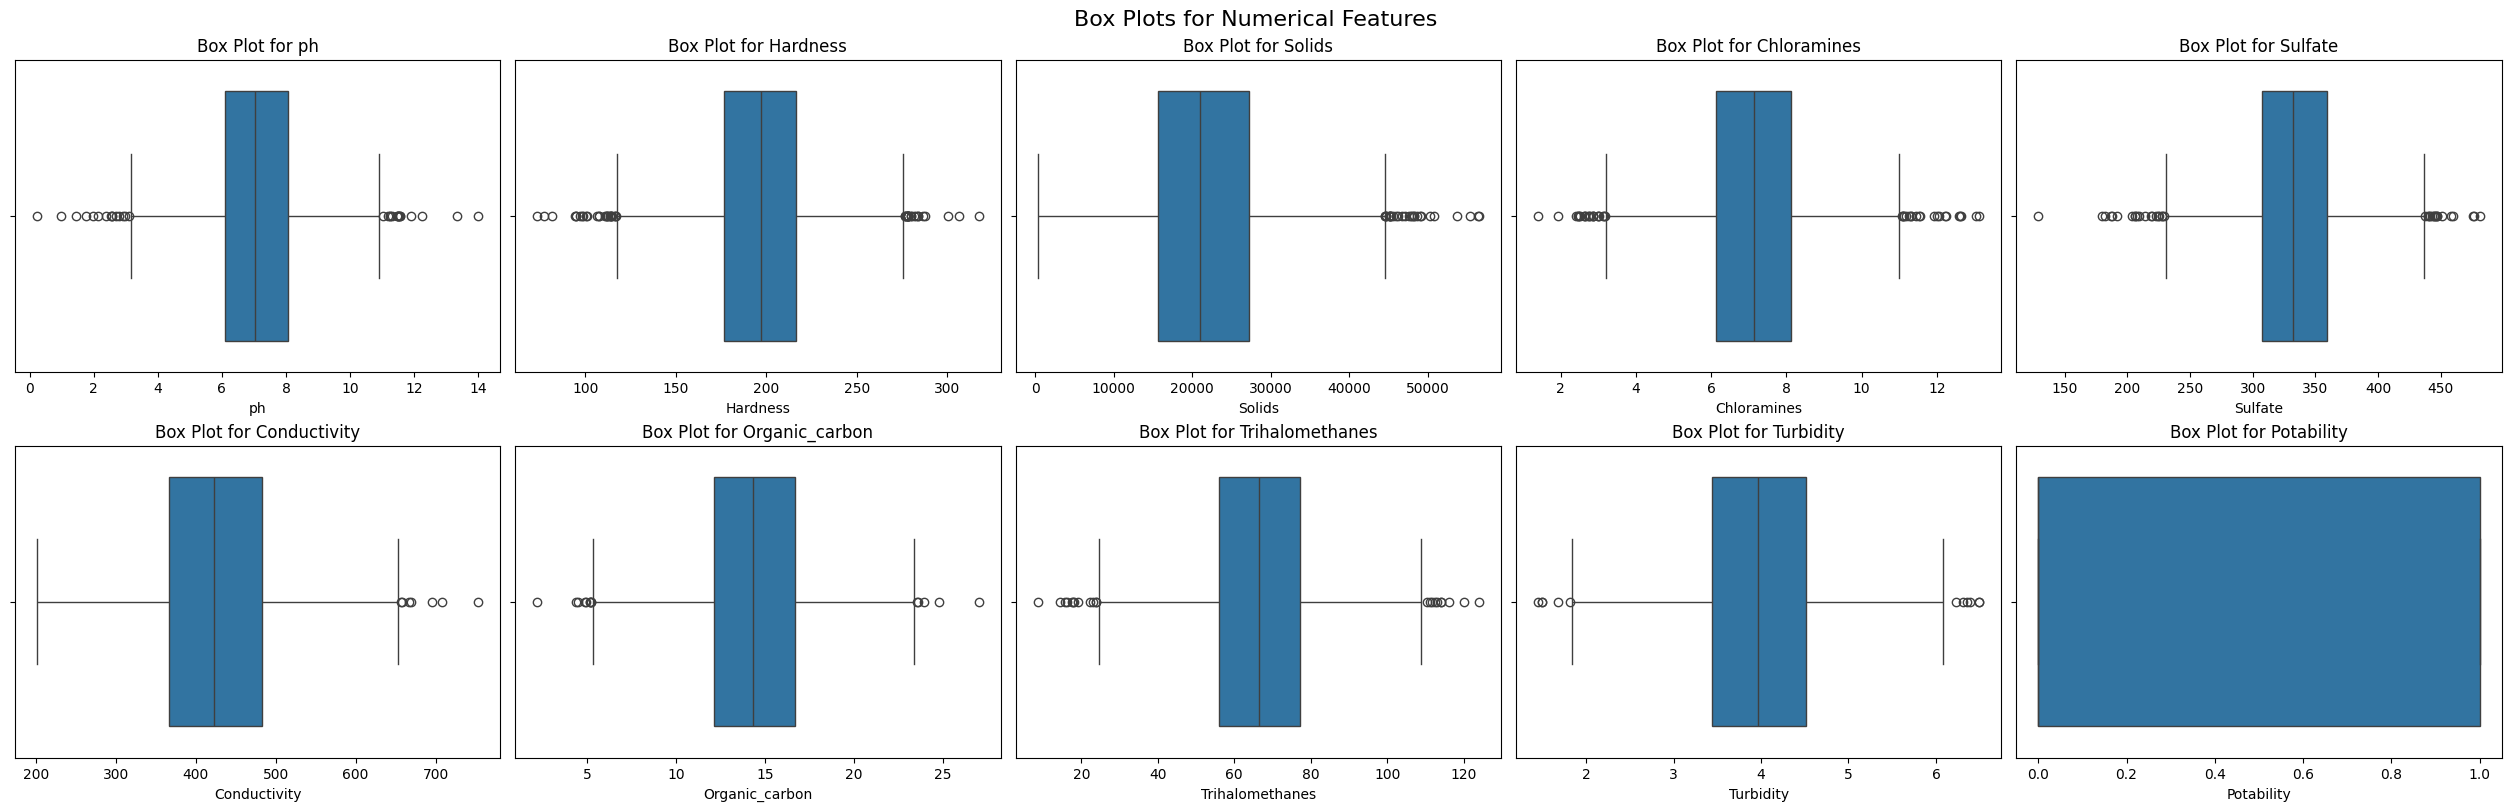

In [96]:
# Select numerical columns for box plot visualization
numeric_columns = data.select_dtypes(include=['number']).columns
num_plots = len(numeric_columns)

# Set number of columns for subplots (adjust as needed)
cols = 5
rows = (num_plots // cols) + (num_plots % cols > 0)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)
axes = axes.flatten()

# Generate box plots for each numeric column
for idx, col in enumerate(numeric_columns):
    sns.boxplot(x=data[col], ax=axes[idx])
    axes[idx].set_title(f'Box Plot for {col}')
    axes[idx].set_xlabel(col)

# Remove any unused subplots if the grid is larger than the number of columns
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Box Plots for Numerical Features', fontsize=16)
plt.show()


In [97]:
# Select numerical columns
numeric_columns = data.select_dtypes(include=['number']).columns

# Create a copy of the original DataFrame for outlier removal
clean_data = data.copy()

# Remove outliers based on the IQR method for each numeric column
for col in numeric_columns:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = clean_data[col].quantile(0.25)
    Q3 = clean_data[col].quantile(0.75)
    
    # Compute the IQR
    IQR = Q3 - Q1
    
    # Define the acceptable bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the data to remove outliers
    clean_data = clean_data[(clean_data[col] >= lower_bound) & (clean_data[col] <= upper_bound)]
    
# Display the number of rows before and after outlier removal
print("Original number of rows:", data.shape[0])
print("Number of rows after outlier removal:", clean_data.shape[0])


Original number of rows: 2011
Number of rows after outlier removal: 1789


Too many rows lost as outliers, hence wont be removing outliers

<h3>Univariate Analysis</h3>

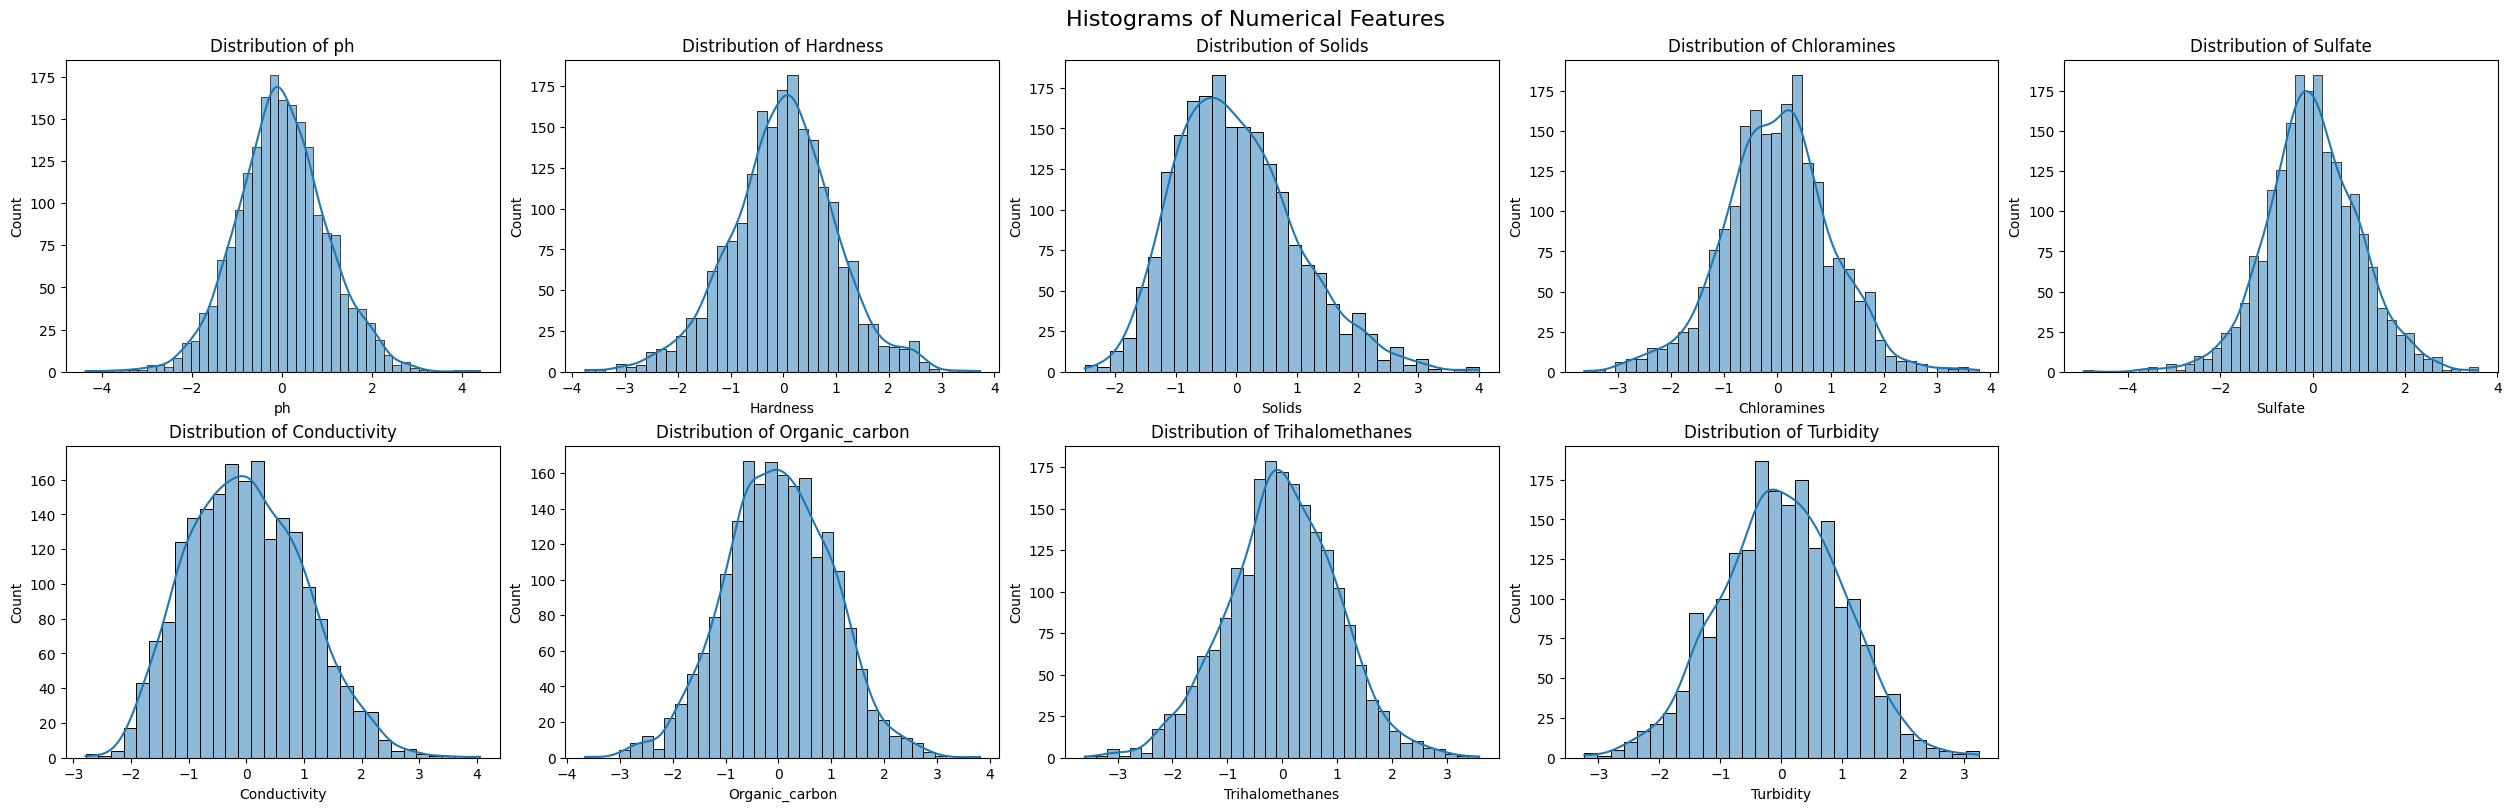

In [98]:
# Number of columns to be plotted
columns_to_plot = data_scaled.columns[:-1]
num_plots = len(columns_to_plot)

# Define the grid dimensions (e.g., 3 columns per row)
cols = 5
rows = (num_plots // cols) + (num_plots % cols > 0)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4), constrained_layout=True)

# Flatten the axes array for easy iteration (if needed)
axes = axes.flatten()

# Plot each column's histogram with KDE on a separate subplot
for idx, col in enumerate(columns_to_plot):
    sns.histplot(data_scaled[col], kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)

# Remove any unused subplots if total plots is not a multiple of cols
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.show()


<h3>Bivariate Analysis</h3>

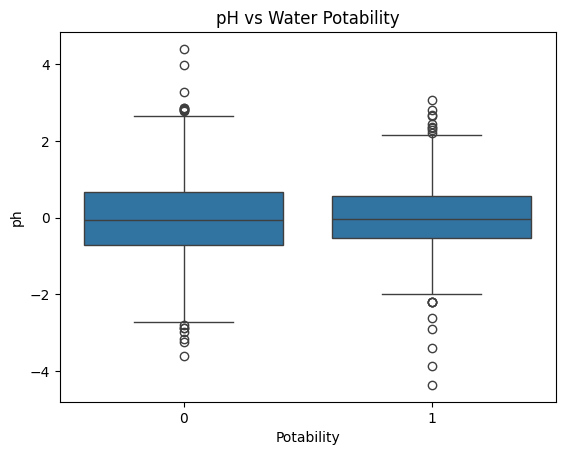

In [99]:


sns.boxplot(x='Potability', y='ph', data=data_scaled)
plt.title("pH vs Water Potability")
plt.show()


<h3>Correlation Matrix</h3>

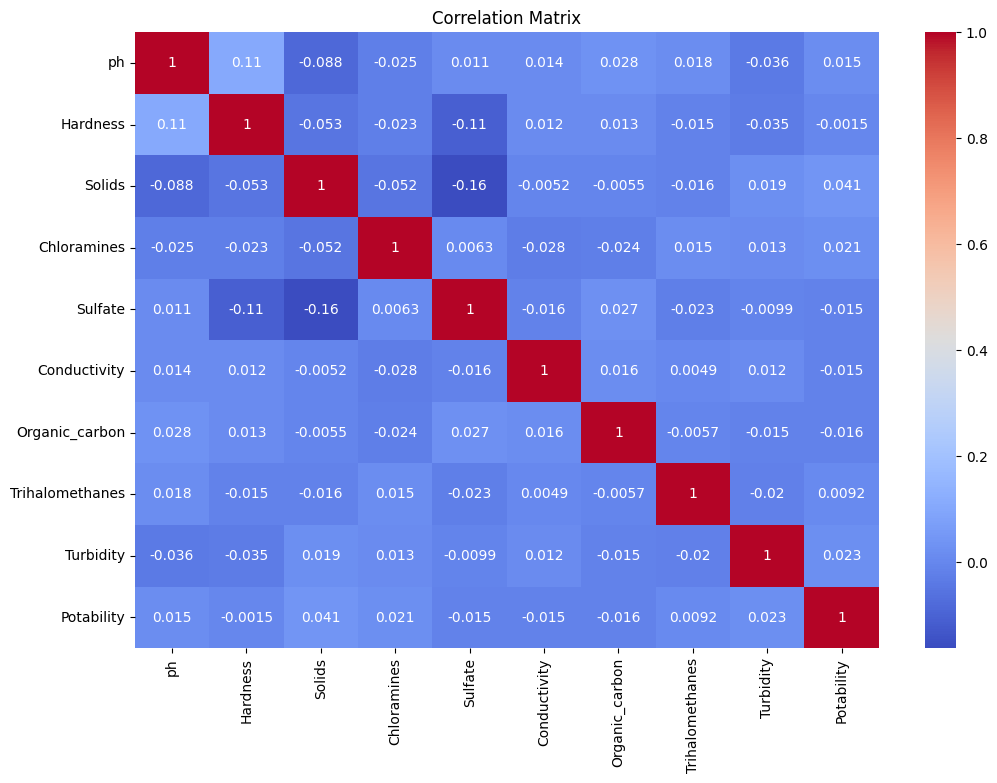

In [100]:
plt.figure(figsize=(12, 8))
sns.heatmap(data_scaled.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


<h2>Model Development</h2>

In [101]:
from sklearn.model_selection import train_test_split

X = data_scaled.drop('Potability', axis=1)
y = data_scaled['Potability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')


Accuracy: 0.66


In [103]:
# Load your preprocessed data 
# Here we assume 'Potability' is your target column
X = data_scaled.drop('Potability', axis=1)
y = data_scaled['Potability']

# Show the original distribution of the target variable
print("Original class distribution:")
print(y.value_counts())

# Initialize the RandomUnderSampler with a fixed random_state for reproducibility
undersampler = RandomUnderSampler(random_state=42)

# Apply under-sampling to the features and target variable
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Check the new class distribution after under-sampling
print("\nClass distribution after under-sampling:")
print(pd.Series(y_resampled).value_counts())

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2,
                                                    random_state=42)

# Now you can proceed to train your model using X_train and y_train,
# and evaluate it on X_test and y_test to see if precision improves.
# Define a parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', 
                                   eval_metric='logloss', 
                                   use_label_encoder=False, 
                                   random_state=42)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1, verbose=1)

# Fit the grid search model on the training data
grid_search.fit(X_train, y_train)

# Extract the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test set
predictions = best_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

X_train.to_csv('data/X_train_for_explainers.csv', index=False)


Original class distribution:
Potability
0    1200
1     811
Name: count, dtype: int64

Class distribution after under-sampling:
Potability
0    811
1    811
Name: count, dtype: int64
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/alokjp/Desktop/Projects/Water-Pollution-Detection-and-Forecasting/Water-Pollution-Detection-and-Forecasting/env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alokjp/Desktop/Projects/Water-Pollution-Detection-and-Forecasting/Water-Pollution-Detection-and-Forecasting/env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alokjp/Desktop/Projects/Water-Pollution-Detection-and-Forecasting/Water-Pollution-Detection-and-Forecasting/env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Confusion Matrix:
[[124  51]
 [ 46 104]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       175
           1       0.67      0.69      0.68       150

    accuracy                           0.70       325
   macro avg       0.70      0.70      0.70       325
weighted avg       0.70      0.70      0.70       325



In [104]:
import joblib
joblib.dump(model, 'models/final_water_quality_model.pkl')


['models/final_water_quality_model.pkl']

Generating SHAP explanation for the first test instance:


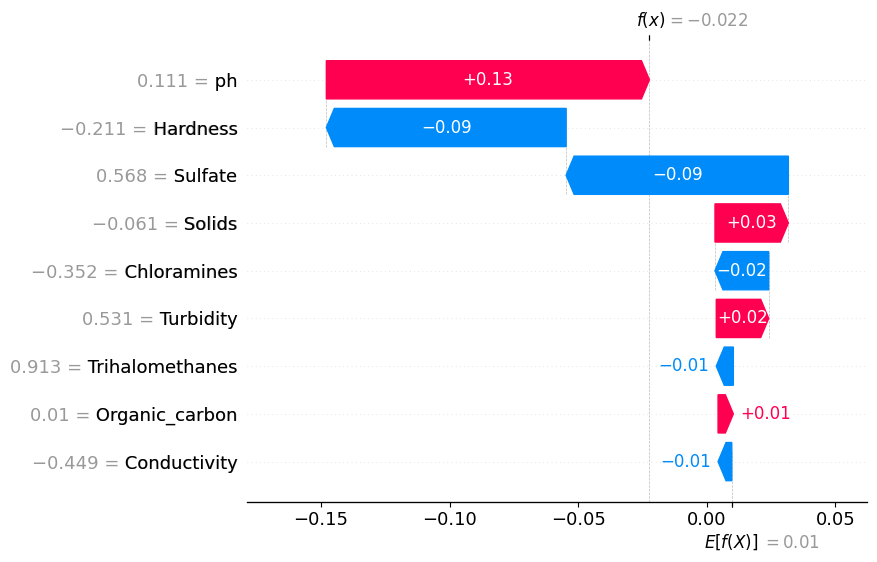

Generating SHAP summary plot for test data:


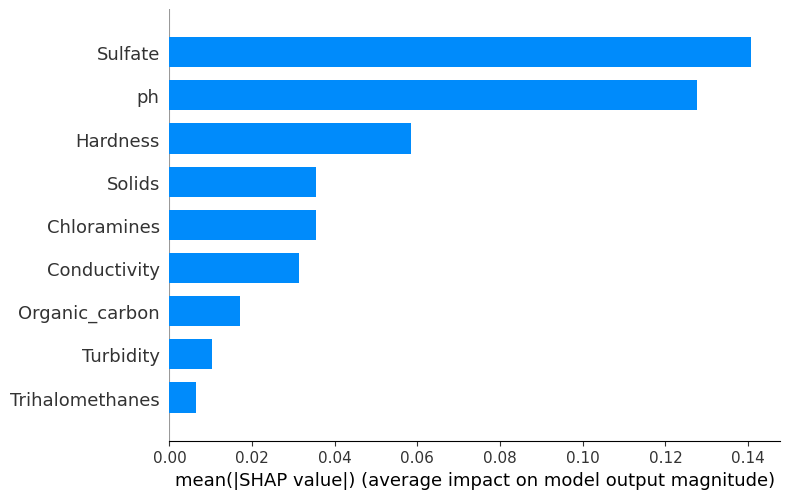

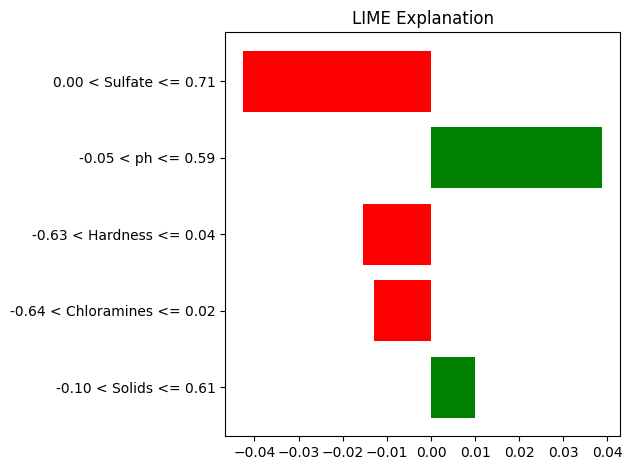

In [105]:
# First, ensure you have installed SHAP and LIME:
# pip install shap lime

import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# -------------------------------
# SHAP EXPLANATIONS
# -------------------------------

# Initialize a SHAP explainer using your trained model and training data.
# This explainer works for many model types; for tree-based models, TreeExplainer could be used.
explainer_shap = shap.Explainer(best_model, X_train)

# Compute SHAP values for the test set.
shap_values = explainer_shap(X_test)

# Visualize the SHAP values for a single test instance.
# A waterfall plot shows how each feature contributes to driving the prediction away from the average.
print("Generating SHAP explanation for the first test instance:")
shap.plots.waterfall(shap_values[0])
plt.show()

# You can also visualize a summary plot to capture feature importance across the entire test set:
print("Generating SHAP summary plot for test data:")
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

# -------------------------------
# LIME EXPLANATIONS
# -------------------------------

import matplotlib.pyplot as plt
import lime
import lime.lime_tabular

# Create the LIME explainer 
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Non-Potable', 'Potable'],
    mode='classification'
)

# Pick an instance from the test set
i = 0  # change this index as needed
instance = X_test.values[i]

# Explain the prediction
exp = explainer.explain_instance(instance, best_model.predict_proba, num_features=5)

# Render the explanation as a matplotlib figure
fig = exp.as_pyplot_figure()
plt.title("LIME Explanation")
plt.tight_layout()
plt.show()

